In [65]:
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import warnings
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from matplotlib.ticker import FuncFormatter
sns.set_style('whitegrid')
np.random.seed(42)

In [66]:
# Get returns for equities with highest market cap
idx = pd.IndexSlice
with pd.HDFStore('data/assets.h5') as store:
    stocks = store['us_equities/stocks'].marketcap.nlargest(500)
    returns = (store['quandl/wiki/prices'].loc[idx['2010': '2018', stocks.index], 'adj_close']
               .unstack('ticker').pct_change())

returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2072 entries, 2010-01-04 to 2018-03-27
Columns: 351 entries, A to CBRE
dtypes: float64(351)
memory usage: 5.6 MB


In [67]:
returns.tail()

ticker,A,AAL,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,...,INFO,HLT,BHGE,ANDV,DWDP,IQV,APTV,BKNG,WELL,CBRE
date,,,,,,,,,,,,,,,,,,,,,
2018-03-21,-0.006442,-0.022234,-0.022655,0.003476,-0.005782,-0.003671,-0.005219,-0.012622,0.000971,-0.008145,...,-0.006314,0.006023,0.037186,0.019413,0.015665,-0.006679,0.003301,0.002744,-0.013170,NaN
2018-03-22,-0.027810,-0.032908,-0.014159,-0.050279,-0.020252,-0.023871,-0.072826,-0.027904,-0.024353,-0.015955,...,-0.020906,-0.017107,-0.038114,-0.014355,-0.026843,-0.021420,-0.049353,-0.014536,0.005720,NaN
2018-03-23,-0.020898,-0.024852,-0.023128,-0.011412,-0.008380,-0.023470,-0.019171,-0.024941,-0.031367,0.002623,...,-0.018840,-0.028220,-0.019476,-0.000694,-0.039012,-0.021201,-0.030791,-0.012674,-0.013649,-0.027108
2018-03-26,0.032395,0.016663,0.047472,0.010948,0.040177,0.026387,0.037326,0.064599,0.061688,0.018549,...,0.024749,0.023155,0.024315,0.028951,0.022518,0.019454,0.047162,0.022377,0.002114,0.033835
2018-03-27,-0.017595,-0.018511,-0.025641,-0.011065,-0.030366,-0.012936,-0.026104,-0.066008,-0.022124,0.000934,...,0.011868,-0.014879,-0.023738,-0.021777,-0.013027,-0.015739,-0.008349,-0.026316,0.021864,-0.001497


In [68]:
returns = returns.clip(lower=returns.quantile(q=.025), upper=returns.quantile(q=.975), axis=1)
# Since PCA does not permit missing data, it will be removed data for at least 95% of the time period[0] &
# trading days that don't have observations
returns = returns.dropna(thresh=int(returns.shape[0] * .95), axis=1)
returns = returns.dropna(thresh=int(returns.shape[1] * .95))
returns.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2071 entries, 2010-01-05 to 2018-03-27
Columns: 315 entries, A to LYB
dtypes: float64(315)
memory usage: 5.0 MB


In [69]:
returns.describe()

ticker,A,AAL,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,...,WPP,WY,WYNN,XEL,XLNX,XOM,YUM,ZBH,CHTR,LYB
count,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,...,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2071.000000,2070.000000,1992.000000
mean,0.000767,0.001348,0.000974,0.000744,0.002041,0.000647,0.000839,0.000938,0.000606,0.000508,...,-0.000028,0.000580,0.000900,0.000622,0.000714,0.000243,0.000828,0.000467,0.001125,0.001197
std,0.015529,0.025653,0.013926,0.011523,0.021125,0.009933,0.011338,0.014114,0.013857,0.013376,...,0.016820,0.014606,0.021986,0.008885,0.013614,0.010068,0.012071,0.011979,0.014772,0.018311
min,-0.037585,-0.053605,-0.031176,-0.028378,-0.043278,-0.022314,-0.026269,-0.032279,-0.030981,-0.031140,...,-0.041339,-0.033390,-0.047670,-0.019461,-0.030540,-0.022744,-0.028331,-0.028173,-0.031627,-0.043503
25%,-0.007488,-0.013978,-0.006876,-0.005877,-0.010982,-0.005301,-0.005681,-0.007281,-0.007143,-0.007387,...,-0.007340,-0.008080,-0.011465,-0.004898,-0.007629,-0.005649,-0.006091,-0.006618,-0.007529,-0.008987
50%,0.000684,0.000919,0.000755,0.000946,0.001427,0.000430,0.000947,0.000761,0.000617,0.000638,...,0.000000,0.000627,-0.000068,0.000661,0.000824,0.000109,0.000783,0.000454,0.000095,0.001338
75%,0.010116,0.016482,0.009630,0.008162,0.014762,0.006849,0.007449,0.009584,0.008794,0.008447,...,0.007006,0.009398,0.012797,0.006654,0.008998,0.006407,0.007822,0.008097,0.008875,0.011944
max,0.035853,0.064367,0.032937,0.025861,0.054062,0.022112,0.026691,0.032390,0.031685,0.030667,...,0.042853,0.032885,0.056186,0.019106,0.031460,0.023626,0.028776,0.026937,0.039388,0.040893


In [70]:
# impute remaining missing values by daily_avg
daily_avg = returns.mean(1) # same with returns.mean(axis=1)
returns = returns.apply(lambda x: x.fillna(daily_avg))
returns.head()

ticker,A,AAL,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,...,WPP,WY,WYNN,XEL,XLNX,XOM,YUM,ZBH,CHTR,LYB
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,-0.010863,0.064367,0.001729,-0.007135,-0.024027,-0.008079,0.006180,0.016446,-0.001579,0.005402,...,-0.015437,0.021229,0.056186,-0.011860,-0.012608,0.003905,-0.003420,0.026937,0.003152,0.003152
2010-01-06,-0.003553,-0.041431,-0.015906,-0.009455,-0.015240,0.005553,0.010631,-0.002122,-0.001898,-0.002528,...,-0.016551,-0.011057,-0.013117,0.001920,-0.006784,0.008643,-0.007149,-0.000323,0.000000,0.001459
2010-01-07,-0.001297,0.029470,-0.001849,-0.016037,0.000000,0.008284,-0.000935,-0.019405,-0.007921,-0.010456,...,-0.022143,-0.004472,0.021356,-0.004312,-0.010044,-0.003142,-0.000288,0.022940,0.000000,0.003941
2010-01-08,-0.000325,-0.019084,0.006648,0.010865,-0.020238,0.005112,-0.003978,-0.005422,0.005749,-0.012488,...,-0.003623,-0.009209,-0.007165,0.000481,0.014610,-0.004011,0.000288,-0.021004,-0.031627,0.002033
2010-01-11,0.000649,-0.019455,-0.008822,0.011132,-0.018226,0.005086,-0.000940,-0.013083,-0.005716,0.000649,...,-0.013636,0.006574,-0.003240,0.009620,-0.010400,0.011220,0.017281,0.022100,0.000000,0.002875


In [71]:
returns.isna()[:5]

ticker,A,AAL,AAPL,ABC,ABMD,ABT,ACN,ADBE,ADI,ADM,...,WPP,WY,WYNN,XEL,XLNX,XOM,YUM,ZBH,CHTR,LYB
date,,,,,,,,,,,,,,,,,,,,,
2010-01-05,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2010-01-06,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2010-01-07,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2010-01-08,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2010-01-11,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [72]:
returns.mean(1)[:5]

date
2010-01-05    0.003152
2010-01-06    0.001459
2010-01-07    0.003941
2010-01-08    0.002033
2010-01-11    0.002875
dtype: float64

In [73]:
cov = np.cov(returns, rowvar=False)
pca = PCA(n_components='mle')
pca.fit(returns)

PCA(n_components='mle')

In [74]:
returns.shape

(2071, 315)

1    0.398846
2    0.438774
3    0.465614
4    0.489765
5    0.505945
6    0.521067
7    0.532634
dtype: float64

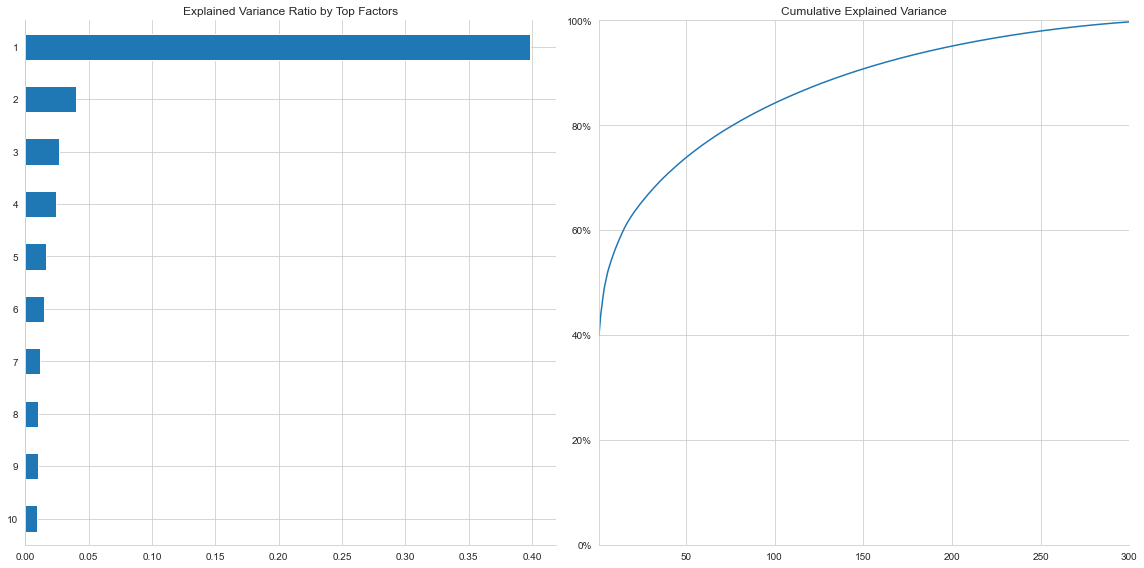

In [75]:
fig, axes = plt.subplots(ncols=2, figsize=(16, 8))
title = 'Explained Variance Ratio by Top Factors'
var_expl = pd.Series(pca.explained_variance_ratio_)
var_expl.index += 1
var_expl.iloc[:10].sort_values().plot.barh(title=title, ax=axes[0])
var_expl.cumsum().plot(ylim=(0, 1), ax=axes[1], title='Cumulative Explained Variance', xlim=(1, 300))
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
sns.despine()
fig.tight_layout()
var_expl.cumsum()[:7]

In [76]:
# Factor extracted from the PCA can get from the returns * eigenvector
# correlation btw factors is the diagonal matrix consisting of eigenvalues
# therefore, principal components are uncorrelated and their variance can explain by eigenvalue
# Since PCA finds the factor that can explain the high variance relatively, the principal components extracted by PCA could ignore the important risk premium at low variance. Moreover, it doesn't support the independent btw factors(esp, when the distribution of data doesn't normally-distributed)
# *Input Data have to normal distribution to keep independence btw principal components(Stock data often violates this assumption) + hard to explain the PCA results
risk_factors = pd.DataFrame(pca.transform(returns)[:, :2],
                            columns=['Principal Component 1', 'Principal Component 2'], index=returns.index)
risk_factors.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2071 entries, 2010-01-05 to 2018-03-27
Data columns (total 2 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Principal Component 1  2071 non-null   float64
 1   Principal Component 2  2071 non-null   float64
dtypes: float64(2)
memory usage: 48.5 KB


In [77]:
risk_factors.tail()

,Principal Component 1,Principal Component 2
date,,
2018-03-21,-0.015085,-0.186004
2018-03-22,0.399421,-0.032678
2018-03-23,0.331477,-0.104130
2018-03-26,-0.393019,0.065520
2018-03-27,0.258617,-0.029003


In [78]:
# to check uncorrelated relationship btw PC1 and PC2
risk_factors['Principal Component 1'].corr(risk_factors['Principal Component 2'])

6.846131982365e-15

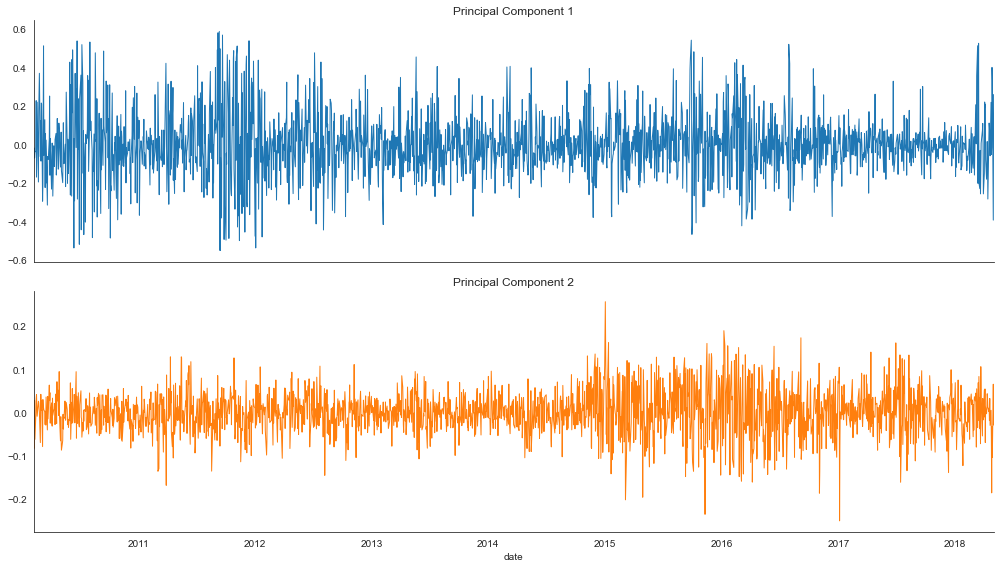

In [79]:
with sns.axes_style('white'):
    risk_factors.plot(subplots=True, figsize=(14, 8), title=risk_factors.columns.tolist(), legend=False,
                      rot=0, lw=1, xlim=(risk_factors.index.min(), risk_factors.index.max()))
    sns.despine()
    plt.tight_layout()

In [80]:
# Simulation for larger number of stocks
idx = pd.IndexSlice
with pd.HDFStore('data/assets.h5') as store:
    returns = (store['quandl/wiki/prices'].loc[idx['2000': '2018', :], 'adj_close'].unstack('ticker')
              .pct_change())
pca = PCA()
n_trials, n_samples = 100, 500
explained = np.empty(shape=(n_trials, n_samples))
for trial in range(n_trials):
    returns_sample = returns.sample(n=n_samples)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[0] * .95), axis=1)
    returns_sample = returns_sample.dropna(thresh=int(returns_sample.shape[1] * .95))
    daily_avg = returns_sample.mean(1)
    returns_sample = returns_sample.apply(lambda x: x.fillna(daily_avg))
    pca.fit(returns_sample)
    explained[trial, :len(pca.components_)] = pca.explained_variance_ratio_
explained = pd.DataFrame(explained, columns=list(range(1, explained.shape[1] + 1)))
explained.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Columns: 500 entries, 1 to 500
dtypes: float64(500)
memory usage: 390.8 KB


In [87]:
explained.head()

,1,2,3,4,5,6,7,8,9,10,...,491,492,493,494,495,496,497,498,499,500
0,0.355039,0.112238,0.055750,0.018067,0.015793,0.015335,0.010207,0.009042,0.006815,0.006509,...,6.130565e-05,5.963017e-05,5.442261e-06,3.455507e-06,7.010288e-32,2.335857e-33,7.635948e-34,1.200657e-34,6.281956e-35,1.335235e-35
1,0.287704,0.150529,0.040547,0.017319,0.015702,0.012167,0.009150,0.008343,0.007226,0.006730,...,1.950786e-07,4.024947e-13,5.679479e-32,1.370218e-33,1.368923e-33,1.368923e-33,3.259870e-34,1.329721e-34,1.263560e-36,1.675019e-220
2,0.640794,0.204519,0.032474,0.004259,0.002983,0.002438,0.002163,0.001933,0.001823,0.001704,...,1.264588e-31,3.528507e-33,3.525360e-33,3.525360e-33,3.525360e-33,3.525360e-33,3.525360e-33,3.438296e-35,2.914271e-35,7.686764e-36
3,0.563702,0.083491,0.010757,0.008966,0.006916,0.006100,0.005415,0.005004,0.004834,0.004674,...,3.906192e-33,3.906192e-33,3.906192e-33,3.906192e-33,3.906192e-33,3.906192e-33,2.584939e-33,5.645560e-35,4.599644e-35,1.109454e-35
4,0.825711,0.030316,0.004767,0.002947,0.002907,0.002356,0.002203,0.002060,0.002029,0.001841,...,6.643008e-33,6.643008e-33,6.643008e-33,6.643008e-33,6.643008e-33,6.643008e-33,6.642903e-33,7.632665e-35,1.087445e-35,3.670695e-36


,Trial,Principal Component,Value,Cumulative
0,0,1,0.355039,0.355039
1,0,2,0.112238,0.467277
2,0,3,0.055750,0.523027
3,0,4,0.018067,0.541095
4,0,5,0.015793,0.556888
5,0,6,0.015335,0.572223
6,0,7,0.010207,0.582430
7,0,8,0.009042,0.591473
8,0,9,0.006815,0.598287
9,0,10,0.006509,0.604797


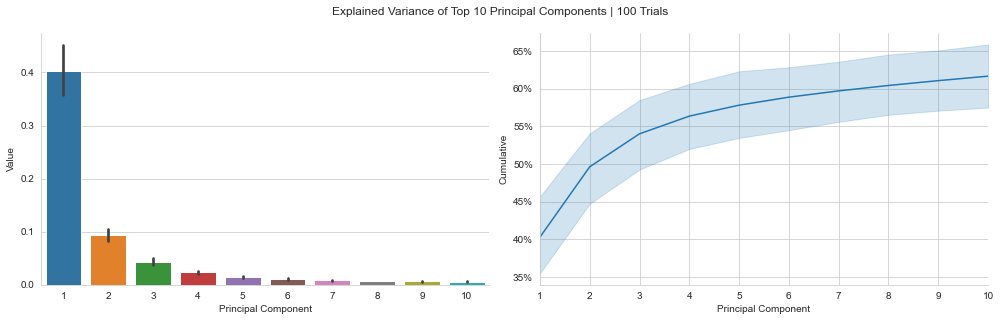

In [82]:
fig, axes = plt.subplots(ncols=2, figsize=(14, 4.5))
pc10 = explained.iloc[:, :10].stack().reset_index()
pc10.columns = ['Trial', 'Principal Component', 'Value']

pc10['Cumulative'] = pc10.groupby('Trial').Value.transform(np.cumsum)
sns.barplot(x='Principal Component', y='Value', data=pc10, ax=axes[0])
sns.lineplot(x='Principal Component', y='Cumulative', data=pc10, ax=axes[1])
axes[1].set_xlim(1, 10)
axes[1].yaxis.set_major_formatter(FuncFormatter(lambda y, _: f'{y:.0%}'))
fig.suptitle('Explained Variance of Top 10 Principal Components | 100 Trials')
sns.despine()
fig.tight_layout()
fig.subplots_adjust(top=.90)
pc10.head(10)